In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout
from keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D,Lambda
from keras.utils.vis_utils import plot_model
from keras import backend as K
import tensorflow as tf

class MuiltiMobileModel():
    def _make_divisible(self, v, divisor, min_value=None):
        if min_value is None:
            min_value = divisor
        new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
        # Make sure that round down does not go down by more than 10%.
        if new_v < 0.9 * v:
            new_v += divisor
        return new_v


    def relu6(self, x):
        """Relu 6
        """
        return K.relu(x, max_value=6.0)


    def _conv_block(self, inputs, filters, kernel, strides):
        """Convolution Block
        This function defines a 2D convolution operation with BN and relu6.
        # Arguments
            inputs: Tensor, input tensor of conv layer.
            filters: Integer, the dimensionality of the output space.
            kernel: An integer or tuple/list of 2 integers, specifying the
                width and height of the 2D convolution window.
            strides: An integer or tuple/list of 2 integers,
                specifying the strides of the convolution along the width and height.
                Can be a single integer to specify the same value for
                all spatial dimensions.
        # Returns
            Output tensor.
        """

        channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

        x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
        x = BatchNormalization(axis=channel_axis)(x)
        return Activation(self.relu6)(x)


    def _bottleneck(self, inputs, filters, kernel, t, alpha, s, r=False):
        """Bottleneck
        This function defines a basic bottleneck structure.
        # Arguments
            inputs: Tensor, input tensor of conv layer.
            filters: Integer, the dimensionality of the output space.
            kernel: An integer or tuple/list of 2 integers, specifying the
                width and height of the 2D convolution window.
            t: Integer, expansion factor.
                t is always applied to the input size.
            s: An integer or tuple/list of 2 integers,specifying the strides
                of the convolution along the width and height.Can be a single
                integer to specify the same value for all spatial dimensions.
            alpha: Integer, width multiplier.
            r: Boolean, Whether to use the residuals.
        # Returns
            Output tensor.
        """

        channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
        # Depth
        tchannel = K.int_shape(inputs)[channel_axis] * t
        # Width
        cchannel = int(filters * alpha)

        x = self._conv_block(inputs, tchannel, (1, 1), (1, 1))

        x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
        x = BatchNormalization(axis=channel_axis)(x)
        x = Activation(self.relu6)(x)

        x = Conv2D(cchannel, (1, 1), strides=(1, 1), padding='same')(x)
        x = BatchNormalization(axis=channel_axis)(x)

        if r:
            x = Add()([x, inputs])

        return x


    def _inverted_residual_block(self, inputs, filters, kernel, t, alpha, strides, n):
        """Inverted Residual Block
        This function defines a sequence of 1 or more identical layers.
        # Arguments
            inputs: Tensor, input tensor of conv layer.
            filters: Integer, the dimensionality of the output space.
            kernel: An integer or tuple/list of 2 integers, specifying the
                width and height of the 2D convolution window.
            t: Integer, expansion factor.
                t is always applied to the input size.
            alpha: Integer, width multiplier.
            s: An integer or tuple/list of 2 integers,specifying the strides
                of the convolution along the width and height.Can be a single
                integer to specify the same value for all spatial dimensions.
            n: Integer, layer repeat times.
        # Returns
            Output tensor.
        """

        x = self._bottleneck(inputs, filters, kernel, t, alpha, strides)

        for i in range(1, n):
            x = self._bottleneck(x, filters, kernel, t, alpha, 1, True)

        return x

    def BaseMobileNet(self, inputs, alpha = 1.0):
        """MobileNetv2
        This function defines a MobileNetv2 architectures.
        # Arguments
            input_shape: An integer or tuple/list of 3 integers, shape
                of input tensor.
            k: Integer, number of classes.
            alpha: Integer, width multiplier, better in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4].
        # Returns
            MobileNetv2 model.
        """

        first_filters = self._make_divisible(32 * alpha, 8)
        x = self._conv_block(inputs, first_filters, (3, 3), strides=(2, 2))

        x = self._inverted_residual_block(x, 16, (3, 3), t=1, alpha=alpha, strides=1, n=1)
        x = self._inverted_residual_block(x, 24, (3, 3), t=6, alpha=alpha, strides=2, n=2)
        x = self._inverted_residual_block(x, 32, (3, 3), t=6, alpha=alpha, strides=2, n=3)
        x = self._inverted_residual_block(x, 64, (3, 3), t=6, alpha=alpha, strides=2, n=4)
        x = self._inverted_residual_block(x, 96, (3, 3), t=6, alpha=alpha, strides=1, n=3)
        x = self._inverted_residual_block(x, 160, (3, 3), t=6, alpha=alpha, strides=2, n=3)
        x = self._inverted_residual_block(x, 320, (3, 3), t=6, alpha=alpha, strides=1, n=1)

        #if alpha > 1.0:
            #last_filters = _make_divisible(1280 * alpha, 8)
        #else:
            #last_filters = 1280

        #x = _conv_block(x, last_filters, (1, 1), strides=(1, 1))
        #x = GlobalAveragePooling2D()(x)
        #x = Reshape((1, 1, last_filters))(x)
        #x = Dropout(0.3, name='Dropout')(x)
        #x = Conv2D(k, (1, 1), padding='same')(x)

        return x

    def build_race_branch(self, inputs, num_races = 5, alpha = 1.0):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        k = num_races
        x = self.BaseMobileNet(inputs, alpha)

        if alpha > 1.0:
            last_filters = _make_divisible(1280 * alpha, 8)
        else:
            last_filters = 1280

        x = self._conv_block(x, last_filters, (1, 1), strides=(1, 1))
        x = GlobalAveragePooling2D()(x)
        x = Reshape((1, 1, last_filters))(x)# this line determines end shape maybe?
        x = Dropout(0.3)(x)
        x = Conv2D(k, (1, 1), padding='same')(x)
        x = Activation('softmax')(x)#this line might change based on the activation we want, here softmax is fine
        #output = Reshape((k,))(x) //We're not returning output here but we DO want to reshape
        x = Reshape((k,))(x)
        
        #i dont think the stuff below this really applies to mobile net. its part of the model rodrigobressan uses, not mobile net.
        #x = Flatten()(x)
        #x = Dense(128)(x)
        #x = Activation("relu")(x)
        #x = BatchNormalization()(x)
        #x = Dropout(0.5)(x)
        #x = Dense(num_races)(x)
        #x = Activation("softmax", name="race_output")(x)
        print(type(x))
        return x

    def build_gender_branch(self, inputs, num_genders=2, alpha = 1.0):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
        k = num_genders
        x = self.BaseMobileNet(inputs, alpha)
        if alpha > 1.0:
            last_filters = _make_divisible(1280 * alpha, 8)
        else:
            last_filters = 1280

        x = self._conv_block(x, last_filters, (1, 1), strides=(1, 1))
        x = GlobalAveragePooling2D()(x)
        x = Reshape((1, 1, last_filters))(x)# this line determines end shape maybe?
        x = Dropout(0.3)(x)
        x = Conv2D(k, (1, 1), padding='same')(x)
        x = Activation('softmax')(x)#this line might change based on the activation we want, here should we be using sigmoid?

        #output = Reshape((k,))(x) //We're not returning output here but we DO want to reshape
        x = Reshape((k,))(x)
    
        #i dont think the stuff below this really applies to mobile net. its part of the model rodrigobressan uses, not mobile net.
        #x = Flatten()(x)
        #x = Dense(128)(x)
        #x = Activation("relu")(x)
        #x = BatchNormalization()(x)
        #x = Dropout(0.5)(x)
        #x = Dense(num_genders)(x)
        #x = Activation("sigmoid", name="gender_output")(x)

        return x

    def build_age_branch(self, inputs, alpha = 1.0):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.

        """
        k = 1 #?
        x = self.BaseMobileNet(inputs, alpha)

        if alpha > 1.0:
            last_filters = self._make_divisible(1280 * alpha, 8)
        else:
            last_filters = 1280

        x = self._conv_block(x, last_filters, (1, 1), strides=(1, 1))
        x = GlobalAveragePooling2D()(x)
        x = Reshape((1, 1, last_filters))(x)# this line determines end shape maybe?
        x = Dropout(0.3)(x)
        x = Conv2D(k, (1, 1), padding='same')(x)
        x = Activation('softmax')(x)#this line might change based on the activation we want, here should we be using linear?

        #output = Reshape((k,))(x) //We're not returning output here but we DO want to reshape
        x = Reshape((k,))(x)
    
        #i dont think the stuff below this really applies to mobile net. its part of the model rodrigobressan uses, not mobile net.

        #x = Flatten()(x)
        #x = Dense(128)(x)
        #x = Activation("relu")(x)
        #x = BatchNormalization()(x)
        #x = Dropout(0.5)(x)
        #x = Dense(1)(x)
        #x = Activation("linear", name="age_output")(x)

        return x

    def build_multi_model(self, input_shape): #def MobileNetv2(input_shape, k, alpha=1.0):
        inputs = Input(shape=input_shape)
        #x = Activation('softmax', name='softmax')(x)
        #print(x)
        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs)
        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs, outputs = [age_branch, race_branch, gender_branch], name="face_net")
        # plot_model(model, to_file='images/MobileNetv2.png', show_shapes=True)
        return model

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
    #model = MobileNetv2((192, 192, 3), 100, 1.0)  v why 192?
    model = MuiltiMobileModel().build_multi_model((192,192,3))
    #print(model.summary())

<class 'keras.engine.keras_tensor.KerasTensor'>


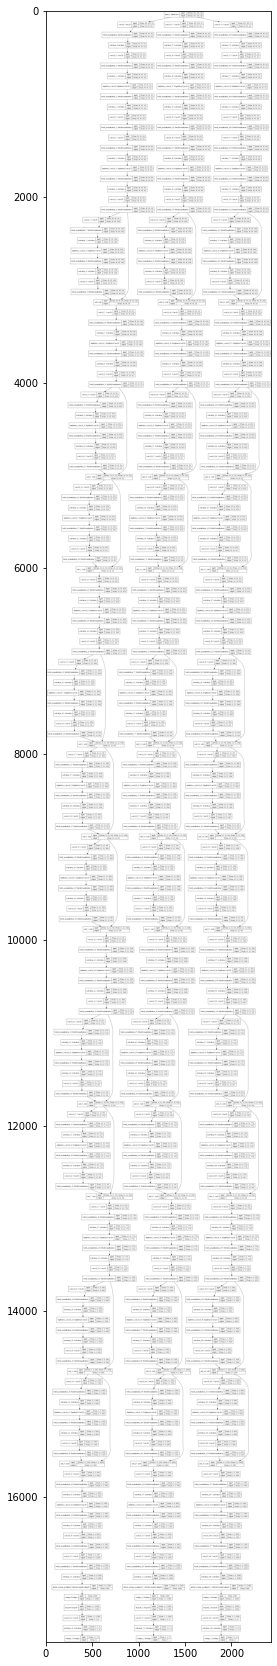

In [3]:
%matplotlib inline

from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plot_model(model, to_file='model.png', show_shapes=True)
img = mpimg.imread('model.png')

plt.figure(figsize=(40, 30))
plt.imshow(img)